In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

# Necessary

- Create VE
- Create dataset

In [2]:
import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models
import utils.dataset as my_dataset
import utils.embeddings_functions as my_embs
import utils.scanning as my_scanning

import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns

print(torch.__version__)

2.5.0+cu121


In [12]:
# Configuration / hyperparameters
config = {
    "SEED": 42,             # Random seed

    "NUM_EPOCHS": 150,       # Total Epochs in training
    "EVAL_EPOCH_FREQ": 5,   # Evaluation frequency
    "BATCH_SIZE": 128,       # Batch size
    "LR": 1e-5,             # Learning rate
    "LR_DECAY_GAMMA": 0.8,    # Learning rate decays
    "LR_DECAY_STEPS_EPOCHS": 2, # Learning rate decay steps
    "L2_REG": 0.01, # avoid to big weigths (imprve generalisation) (1 - weigths)

    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t36_3B_UR50D",#"facebook/esm2_t33_650M_UR50D", #"facebook/esm2_t12_35M_UR50D", #"facebook/esm2_t6_8M_UR50D", # ESM2 model name --> if nto isntalled, autocally dowlaoded
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)

    "DATASET_PATH": "/home/gdallagl/myworkdir/data/cell_cycle/datasets/protein_classification_cluster_43_leiden_all_initial_loose.csv", #"/home/gdallagl/myworkdir/ESMSec/data/secreted/dataset_lysoVSsecreted.csv", #'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/cc_dataset_final.csv', #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/nucleolus_final_dataset.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv",  #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/only-guaranteed_cell-cycle-dataset_2:3.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv", 
    "PATH_TO_SAVE_MODEL": "/home/gdallagl/myworkdir/ESMSec/data/trained_models/cell_cycle_trained_model.pth", # Path to save the model
    
    "TYPE_HEAD":"MLP",# "attention", #"MLP", "LR", gating_transformer
    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",cls, stacked_linearized_all
    "FROM_PRECOMPUTED_EMBS": True,
}
config["PRECOMPUTED_EMBS_PATH"] = os.path.join( # all uniprot human and reviewed
    f"/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs",
    f"entire_reviewed_uniprot_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.safetensors"
)
config["PRECOMPUTED_EMBS_PATH_PROTEIN_NAMES"] =config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json')

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

# Instantiate ESM model

In [4]:
# Load pre-trained ESM model
#esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"]).to(config["DEVICE"])
esm_model = AutoModel.from_pretrained(
    config["PRETRAIN_ESM_CHECKPOINT_NAME"], 
    cache_dir=config["PRETRAIN_ESM_CACHE_DIR"],
    weights_only=False  
).to(config["DEVICE"]) 

# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



# Load dataset and Tokenize

In [5]:
data = pd.read_csv(config["DATASET_PATH"])

num_samples = data.shape[0]
num_classes = data.label.nunique() # ATTENTION: NOT one.hot endoced
esm_emb_dim = esm_model.config.hidden_size
print(num_samples, num_classes, esm_emb_dim)

# ATTENTION:trucnat seqq to enforce max conetxt of EMS
data["truncated_sequence"] = data.sequence.apply(my_dataset.truncate_sequence)

# tokenize truncated seqeunces
    # ATTENTION: they a
print("Tokenizing...")
encoded = tokenizer(
    list(data.truncated_sequence),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)
# add to dict
input_ids_tensor = encoded["input_ids"]          # shape: (N, L)
attention_mask_tensor = encoded["attention_mask"]
# add to df
data["input_ids"] = [tensor for tensor in encoded["input_ids"]]
data["attention_mask"] = [tensor for tensor in encoded["attention_mask"]]

#####################

# save all information needed to tothe model
cache_data = {
    'protein': list(data.protein),
    'label': torch.tensor(data.label.values),
    'set': list(data.set),
    'sequence': list(data.sequence),
    'truncated_sequence': list(data.truncated_sequence),
    'input_ids': input_ids_tensor,
    'attention_mask': attention_mask_tensor,
    'embedding': torch.zeros((num_samples, 1), dtype=torch.float32) # FAKE
}


1323 2 2560
Tokenizing...


# Add or Create embs

Only if "from_precomputed_embs" is True

In [13]:
# add to cache precomputed embs only if needed
if config["FROM_PRECOMPUTED_EMBS"]:

    if not os.path.exists(config["PRECOMPUTED_EMBS_PATH"]):
        msg = f"""
        File containing Uniprot embeddings created with 
            model: {config["PRETRAIN_ESM_CHECKPOINT_NAME"]}
            type embs: {config["TYPE_EMB_FOR_CLASSIFICATION"]}
        not found. 
        Please run 'make_uniprot_esm_embs.ipynb' with correct parameters to create it before continuing.
        """
        raise FileNotFoundError(msg)

    print(f"Reading subset uniprot embs back from file: {config['PRECOMPUTED_EMBS_PATH']}...")

    embs, protein_names_selected = my_dataset.load_embs_safetensor(
        precomputed_embs_path=config["PRECOMPUTED_EMBS_PATH"], # path with tensors
        protein_names_path=config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json'), # path with the prtein names of the tenoser
        protein_to_select=cache_data["protein"] # take all
        )
    cache_data["embedding"] = embs
else:
    print("No precomputed embs")

Reading subset uniprot embs back from file: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/entire_reviewed_uniprot_facebook-esm2_t36_3B_UR50D_cls.safetensors...
Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/entire_reviewed_uniprot_facebook-esm2_t36_3B_UR50D_cls.safetensors
✓ Mapped 20405 embeddings (shape: torch.Size([20405, 2560]))
✓ Loaded 1323 / 1323 embeddings
  Shape: torch.Size([1323, 2560])
  Memory: 12.9 MB


In [14]:
# Degfine classifcatio head dimesion

if config["FROM_PRECOMPUTED_EMBS"]:
    first_emb_shape = cache_data["embedding"].shape  # (N, L, D)
    if len(first_emb_shape) == 1:
        # Aggregated embedding (e.g., [D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[0])
    elif len(first_emb_shape) == 2:
        # Aggregated per sequence (e.g., [L, D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[1])
    elif len(first_emb_shape) == 3:
        # Contextualized embeddings (N, L, D) → use D
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[2])
else:
    # dim embessign sins the output of esm
    config["PRECOMPUTED_EMBS_DIM"] = esm_model.embeddings.word_embeddings.embedding_dim
    #fake embs
    cache_data["embedding"] = torch.zeros((num_samples, 1), dtype=torch.float32)

print(config["PRECOMPUTED_EMBS_DIM"])

2560


Original: 496, Truncated: 496, Tokenized (no pad): 498
Original: 579, Truncated: 579, Tokenized (no pad): 581
Original: 262, Truncated: 262, Tokenized (no pad): 264


protein                  : list length 1323
label                    : Tensor shape (1323,)
set                      : list length 1323
sequence                 : list length 1323
truncated_sequence       : list length 1323
input_ids                : Tensor shape (1323, 1000)
attention_mask           : Tensor shape (1323, 1000)
embedding                : Tensor shape (1323, 2560)


<Axes: >

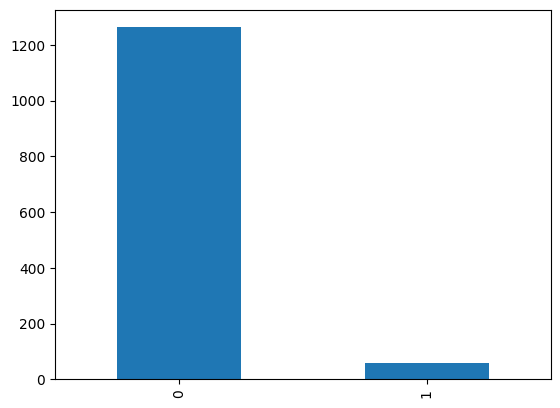

In [15]:
# Plotting

for i in range(3):
    seq = data.sequence.iloc[i]
    trunc_seq = data.truncated_sequence.iloc[i]
    input_ids = input_ids_tensor[i]
    print(f"Original: {len(seq)}, Truncated: {len(trunc_seq)}, Tokenized (no pad): {(input_ids != tokenizer.pad_token_id).sum().item()}")

print("\n")
for key, value in cache_data.items():
    if isinstance(value, torch.Tensor):
        print(f"{key:25s}: Tensor shape {tuple(value.shape)}")
    elif isinstance(value, pd.Series):
        print(f"{key:25s}: pandas Series, length {len(value)}")
    elif isinstance(value, (list, tuple)):
        print(f"{key:25s}: list length {len(value)}")
    else:
        print(f"{key:25s}: type {type(value)}")

data["label"].value_counts().reset_index(drop="True").plot(kind='bar')

# Create DataLoaders

In [16]:
# ATTENTION: the name of the cols in the df must be speicifc
train_indices = [i for i, s in enumerate(cache_data["set"]) if s == "train"] # select indices
train_cache_data = my_dataset.subset_data_dict(cache_data, train_indices) # create cache_data subset
train_dl = my_dataset.create_dataloader(train_cache_data, config["BATCH_SIZE"], shuffle=True) # create dataloader

valid_indices = [i for i, s in enumerate(cache_data["set"]) if s == "val"] 
valid_cache_data = my_dataset.subset_data_dict(cache_data, valid_indices) 
valid_dl = my_dataset.create_dataloader(valid_cache_data, config["BATCH_SIZE"], shuffle=True) 

test_indices = [i for i, s in enumerate(cache_data["set"]) if s == "test"] 
test_cache_data = my_dataset.subset_data_dict(cache_data, test_indices) 
test_dl = my_dataset.create_dataloader(test_cache_data, config["BATCH_SIZE"], shuffle=True) 



# little check:
batch = next(iter(train_dl))

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
labels = batch["label"]
names = batch["name"]
embs = batch["embs"]

print("=== Batch Information ===")
print(f"Batch size: {labels.shape[0]}\n")
print(f"Input IDs: Tensor, shape = {tuple(input_ids.shape)}, dtype = {input_ids.dtype}")
print(f"Attention mask: Tensor, shape = {tuple(attention_mask.shape)}, dtype = {attention_mask.dtype}")
print(f"Labels: Tensor, shape = {tuple(labels.shape)}, dtype = {labels.dtype}")
print(f"First 5 labels: {labels[:5]}")
print(f"Names: List, length = {len(names)}, first 5 = {names[:5]}")
print(f"Embeddings: Tensor, shape = {tuple(embs.shape)}, dtype = {embs.dtype}")


=== Batch Information ===
Batch size: 128

Input IDs: Tensor, shape = (128, 1000), dtype = torch.int64
Attention mask: Tensor, shape = (128, 1000), dtype = torch.int64
Labels: Tensor, shape = (128,), dtype = torch.int64
First 5 labels: tensor([0, 0, 0, 0, 0])
Names: List, length = 128, first 5 = ['Q9BZW8', 'Q6UXN7', 'A0A1B0GUV7', 'Q16827', 'P09630']
Embeddings: Tensor, shape = (128, 2560), dtype = torch.float32


# Instantiate Full model

In [17]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model, 
                           type_head=config["TYPE_HEAD"],
                           type_emb_for_classification=config["TYPE_EMB_FOR_CLASSIFICATION"],
                           from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"],
                           precomputed_embs_dim=config["PRECOMPUTED_EMBS_DIM"],
                           num_classes=num_classes,
                           ).to(config["DEVICE"])
# hidden dim of final embeggin of each aa after trnafoerm 
print(net.class_head)

# Block ESM paramters to be trained
if net.esm_model is not None:
    print("\nESM hidden dim", net.ESM_hidden_dim, "\n")
    for param in net.esm_model.parameters():
        param.requires_grad = False

MLPHead(
  (layer1): Sequential(
    (0): Linear(in_features=2560, out_features=1280, bias=True)
    (1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1280, out_features=628, bias=True)
    (1): LayerNorm((628,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=628, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

ESM hidden dim 2560 



# Define weighted loss fucntion

In [18]:
# Get training data
train_data = data[data.set == "train"].copy()

# Count samples per class using value_counts (this gives you a Series with label as index)
class_counts_series = train_data["label"].value_counts().sort_index()

print("Class counts from training data:")
print(class_counts_series)

# Create a tensor for all classes (0 to num_classes-1)
class_counts = torch.zeros(num_classes, dtype=torch.float32)

# Fill in the counts for classes that exist in training data
for label, count in class_counts_series.items():
    class_counts[label] = count

print(f"\nClass counts tensor (aligned by index): {class_counts}")
print(f"Class distribution: {class_counts / class_counts.sum() * 100}%")

# Calculate weights (inverse frequency)
# Add epsilon to avoid division by zero for missing classes
epsilon = 1e-6
class_weights = 1.0 / (class_counts + epsilon)

# Normalize so weights sum to 1
class_weights = class_weights / class_weights.sum()

print(f"\nClass weights (sum={class_weights.sum():.4f}): {class_weights}")

# Verify the alignment
print("\nVerification:")
for i in range(num_classes):
    print(f"  Class {i}: count={class_counts[i]:.0f}, weight={class_weights[i]:.4f}")

# Create loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(config["DEVICE"]))
#loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.001, 0.999]).to(config["DEVICE"]))

Class counts from training data:
label
0    1010
1      48
Name: count, dtype: int64

Class counts tensor (aligned by index): tensor([1010.,   48.])
Class distribution: tensor([95.4631,  4.5369])%

Class weights (sum=1.0000): tensor([0.0454, 0.9546])

Verification:
  Class 0: count=1010, weight=0.0454
  Class 1: count=48, weight=0.9546


# Train

In [ ]:
#results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config)
results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config, from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]) # precomputed are in the dataloder

### Plot


                         FINAL EVALUATION METRICS
Metric                   Train           Test
---------------------------------------------
Loss                    0.0680         0.0710
Accuracy                99.62%         99.62%
Balanced Acc            99.80%         99.80%
F1 Score                0.9963         0.9963
MCC                     0.9589         0.9589
AUC-ROC                 0.9991         1.0000


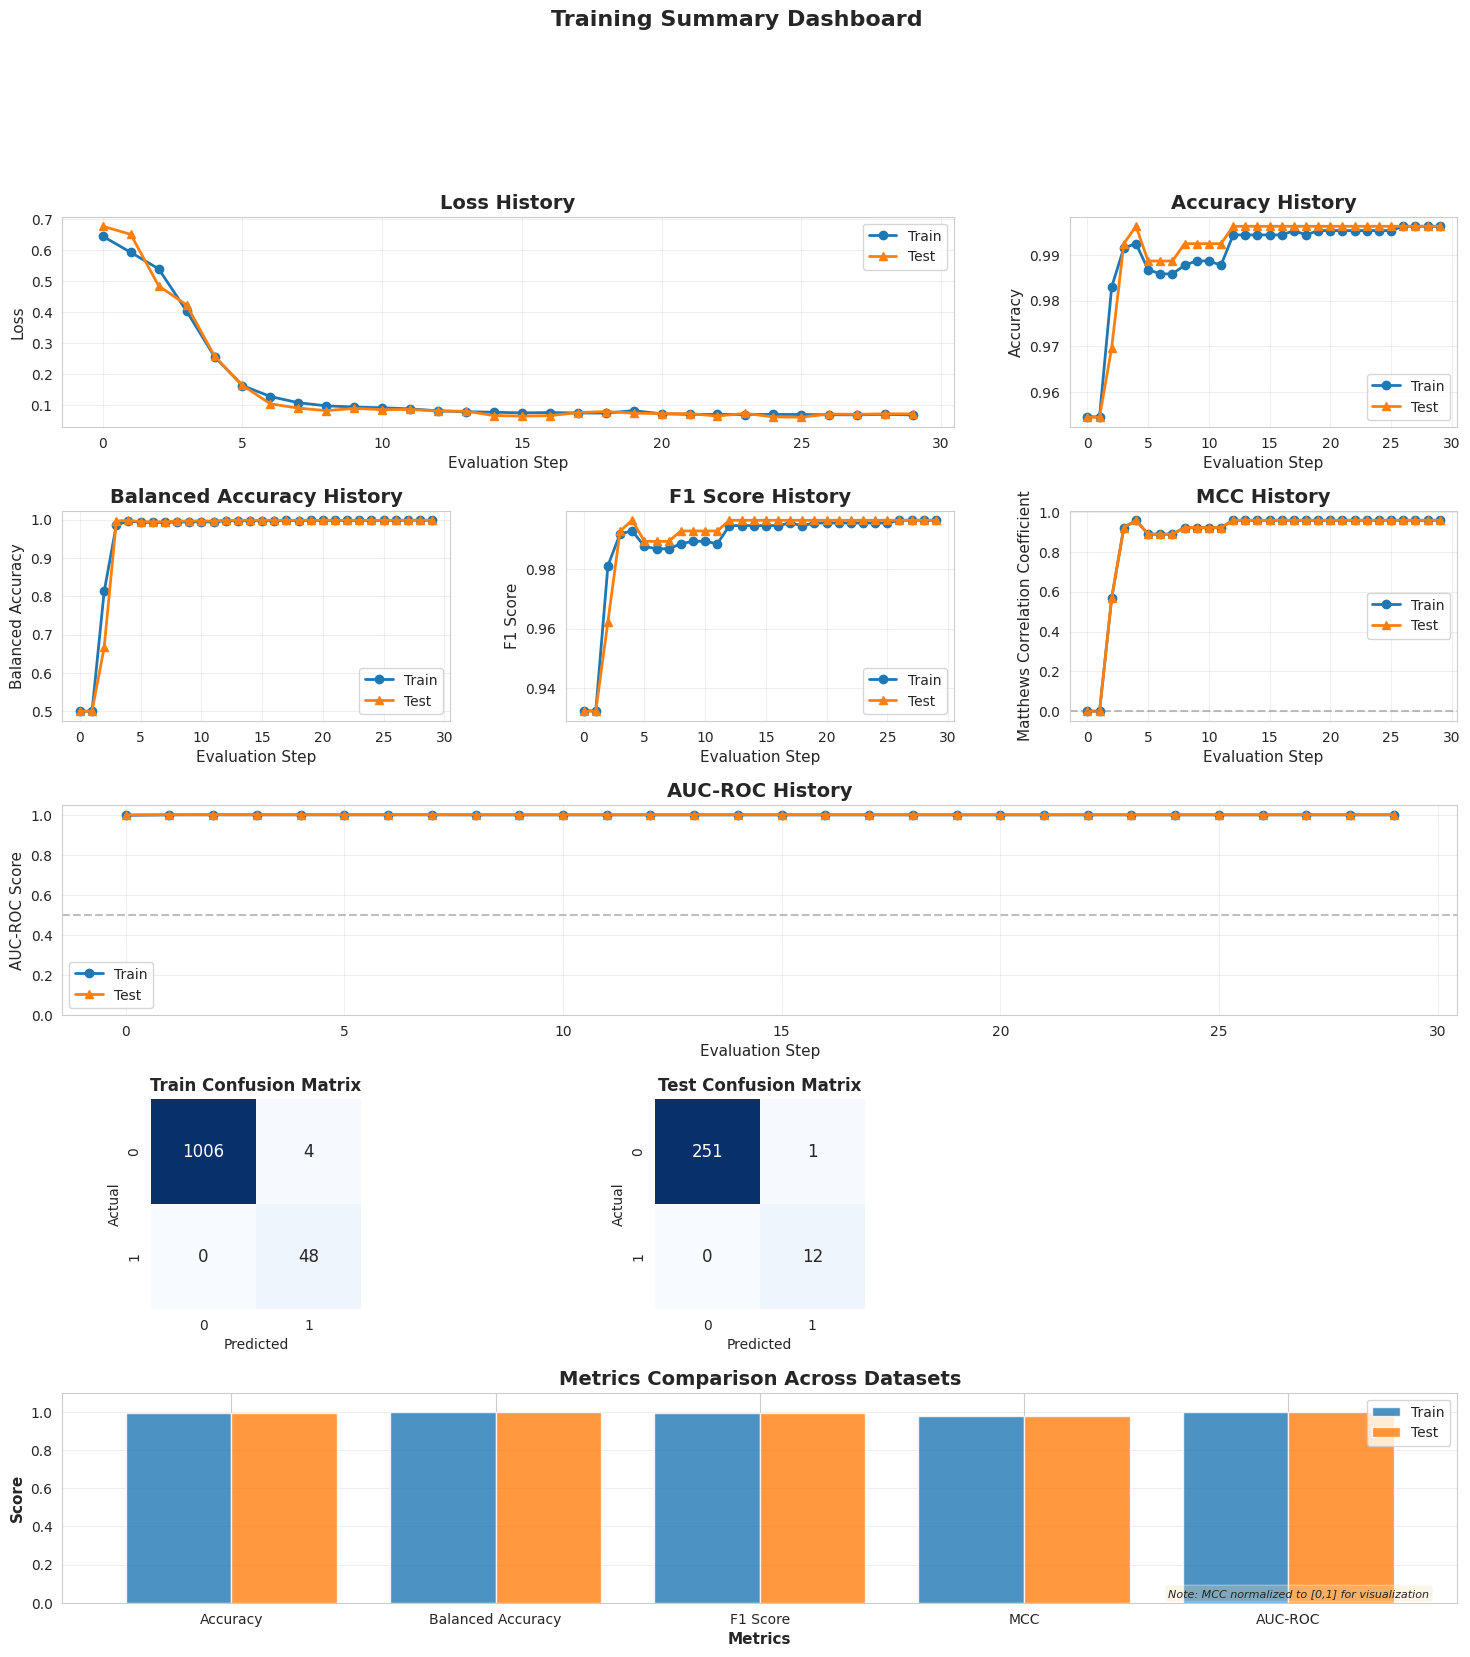


                         TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     1.0000    0.9960    0.9980       252
     Class 1     0.9231    1.0000    0.9600        12

    accuracy                         0.9962       264
   macro avg     0.9615    0.9980    0.9790       264
weighted avg     0.9965    0.9962    0.9963       264



                         TRAIN SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     1.0000    0.9960    0.9980      1010
     Class 1     0.9231    1.0000    0.9600        48

    accuracy                         0.9962      1058
   macro avg     0.9615    0.9980    0.9790      1058
weighted avg     0.9965    0.9962    0.9963      1058




In [20]:
mf.summarize_results(results, num_classes=num_classes, plot_val=False)

### Save Model

In [15]:
#torch.save(net, config["PATH_TO_SAVE_MODEL"])

### Load Model

In [16]:
#net = torch.load(config["PATH_TO_SAVE_MODEL"])
net.eval()

EsmDeepSec(
  (esm_model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 2560, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-35): 36 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=2560, out_features=2560, bias=True)
              (key): Linear(in_features=2560, out_features=2560, bias=True)
              (value): Linear(in_features=2560, out_features=2560, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=2560, out_features=2560, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  


Extracting embeddings from training set...



Batch:   0%|          | 0/9 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
class_head_embs_mlp_layer3: (1058, 32)
precomputed_embs: (1058, 2560)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_mlp_layer3 with shape (1058, 32)...
Computing UMAP for precomputed_embs with shape (1058, 2560)...

Plotting UMAP embeddings...



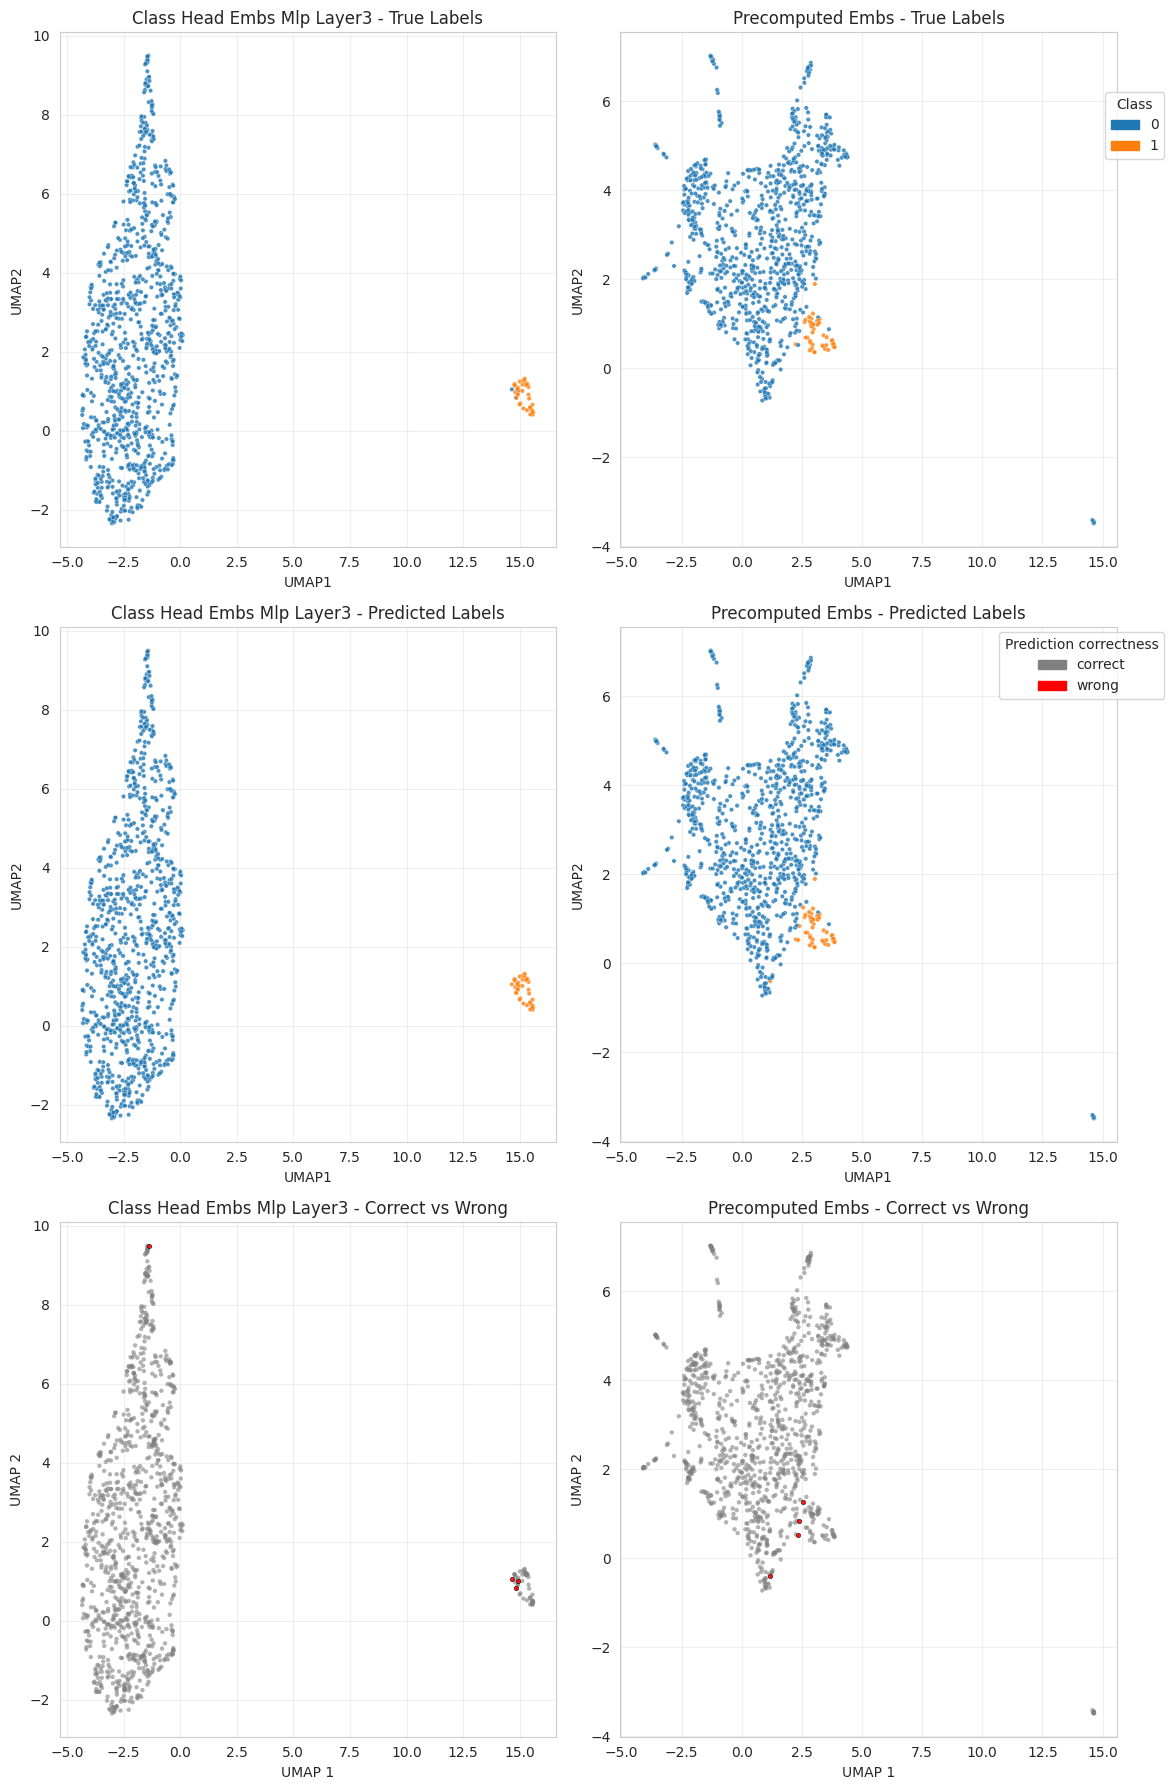

In [21]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

# for key, emb in train_embeddings.items():
#     if emb is not None:
#         print(f"\n{key}:")
#         print(f"  Type: {type(emb)}")
#         print(f"  Shape: {emb.shape}")
#         print(f"  Dtype: {emb.dtype}")
#         print(f"  Contains NaN: {np.isnan(emb).any()}")
#         print(f"  Contains Inf: {np.isinf(emb).any()}")
#         print(f"  Min: {np.nanmin(emb) if emb.size > 0 else 'empty'}")
#         print(f"  Max: {np.nanmax(emb) if emb.size > 0 else 'empty'}")
#         print(f"  All NaN: {np.isnan(emb).all()}")
#     else:
#         print(f"\n{key}: None")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
    #n_neighbors=30,
    #min_dist=0.5
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(
        umap_tensors, 
        names, 
        labels, 
        predictions, 
        class_palette = {str(k): v for k, v in enumerate(sns.color_palette("tab10", num_classes))},
        point_size=10)
else:
    print("No embs to plot")

In [22]:
df_precomputed = df["precomputed_embs"].copy()
#df_precomputed = df["class_head_embs_mlp_layer3"].copy()

Clustering complete. Added 'Cluster_Label' column to the DataFrame.
     Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr  Cluster_Label
0  Q9H6T0 -0.082069  1.955249         0         0    correct              4
1  Q9BZW8 -3.126480  4.736873         0         0    correct              1
2  P78411  3.441849  3.923750         0         0    correct              0
3  P51809  0.504683  0.831348         0         0    correct              4
4  Q9NPF8  1.457461  3.213000         0         0    correct              2


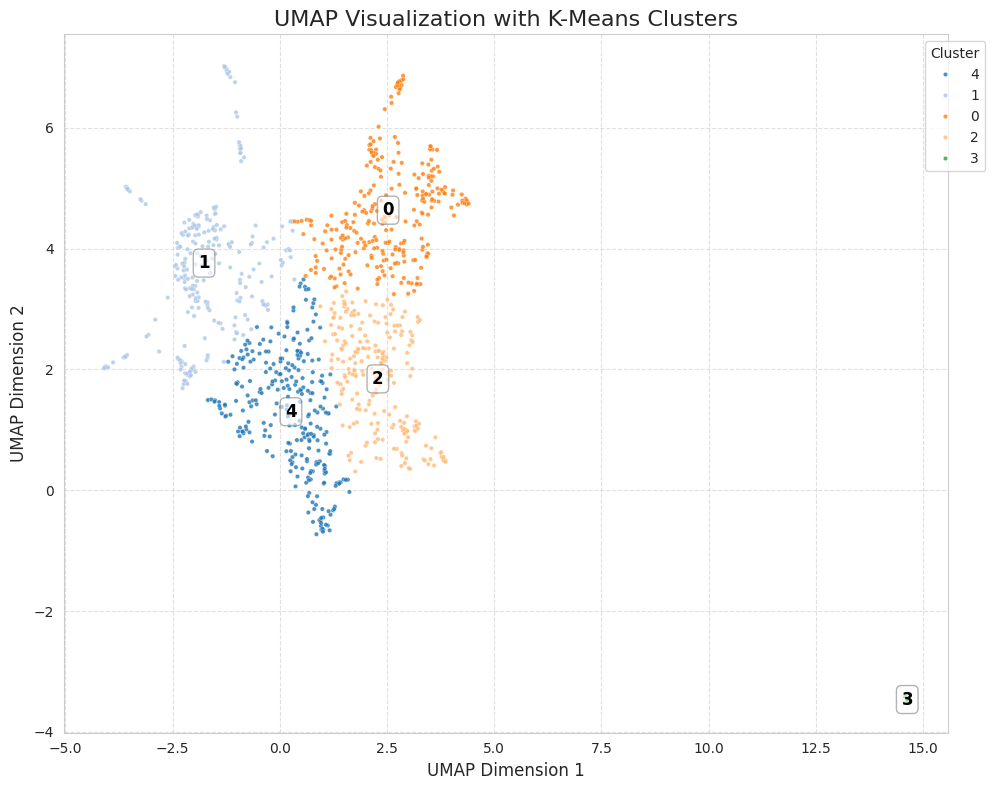

In [23]:
from sklearn.cluster import KMeans

# Define the features for clustering (the UMAP coordinates)
X_for_clustering = df_precomputed[['UMAP1', 'UMAP2']]

# Define the number of clusters (you should optimize this, e.g., using the Elbow Method)
K = 5

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)

# Save the cluster labels back to the DataFrame
df_precomputed['Cluster_Label'] = cluster_labels
print(f"Clustering complete. Added 'Cluster_Label' column to the DataFrame.")
print(df_precomputed.head())

my_embs.plot_umap_clusters(df_precomputed, point_size=10)

In [20]:
print(df_precomputed[df_precomputed.Cluster_Label == 1].Name.to_list()) 
print(df_precomputed[df_precomputed.Cluster_Label == 4].Name.to_list()) 

['P62685', 'P63128', 'Q9YNA8', 'P62684', 'P63126', 'P63130', 'P62683', 'P87889']
['A0A0B4J2A2', 'P0DN37', 'F5H284', 'Q6UX04', 'Q8WUA2', 'P30405', 'O43447', 'Q08752', 'Q9Y536', 'Q9H2H8', 'P23284', 'A0A075B767', 'Q9Y3C6', 'P62937', 'Q13427', 'P0DN26']


In [24]:
# wrong lablled
display(df_precomputed[(df_precomputed.CorrectStr == "correct") & (df_precomputed.TrueClass == "1")].head(5))

print("\nFalse postives")
FP_df = df_precomputed[(df_precomputed.TrueClass == "0") & (df_precomputed.PredClass == "1")]
print(FP_df.Name.to_list())
display(FP_df)

print("\nFalse Negatives")
FN_df = df_precomputed[(df_precomputed.TrueClass == "1") & (df_precomputed.PredClass == "0")]
print(FN_df.Name.to_list())
display(FN_df)

,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr,Cluster_Label
66,Q08170,3.005933,0.365381,1,1,correct,2
72,Q96EP5,3.142951,0.988072,1,1,correct,2
154,P0DJD3,3.797519,0.529643,1,1,correct,2
170,P31483,2.926800,0.950133,1,1,correct,2
198,O75526,3.776282,0.555610,1,1,correct,2



False postives
['P08579', 'Q15717', 'Q5SZQ8', 'Q8N9V3']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr,Cluster_Label
44,P08579,1.184184,-0.404978,0,1,wrong,4
217,Q15717,2.397947,0.834694,0,1,wrong,2
330,Q5SZQ8,2.350691,0.519833,0,1,wrong,2
627,Q8N9V3,2.553422,1.250532,0,1,wrong,2



False Negatives
[]


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr,Cluster_Label



Extracting embeddings from training set...



Batch:  33%|███▎      | 1/3 [00:00<00:00,  7.39 batch/s]

All possbile embedding given current model architecrure:
class_head_embs_mlp_layer3: (264, 32)
precomputed_embs: (264, 2560)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_mlp_layer3 with shape (264, 32)...


Computing UMAP for precomputed_embs with shape (264, 2560)...

Plotting UMAP embeddings...



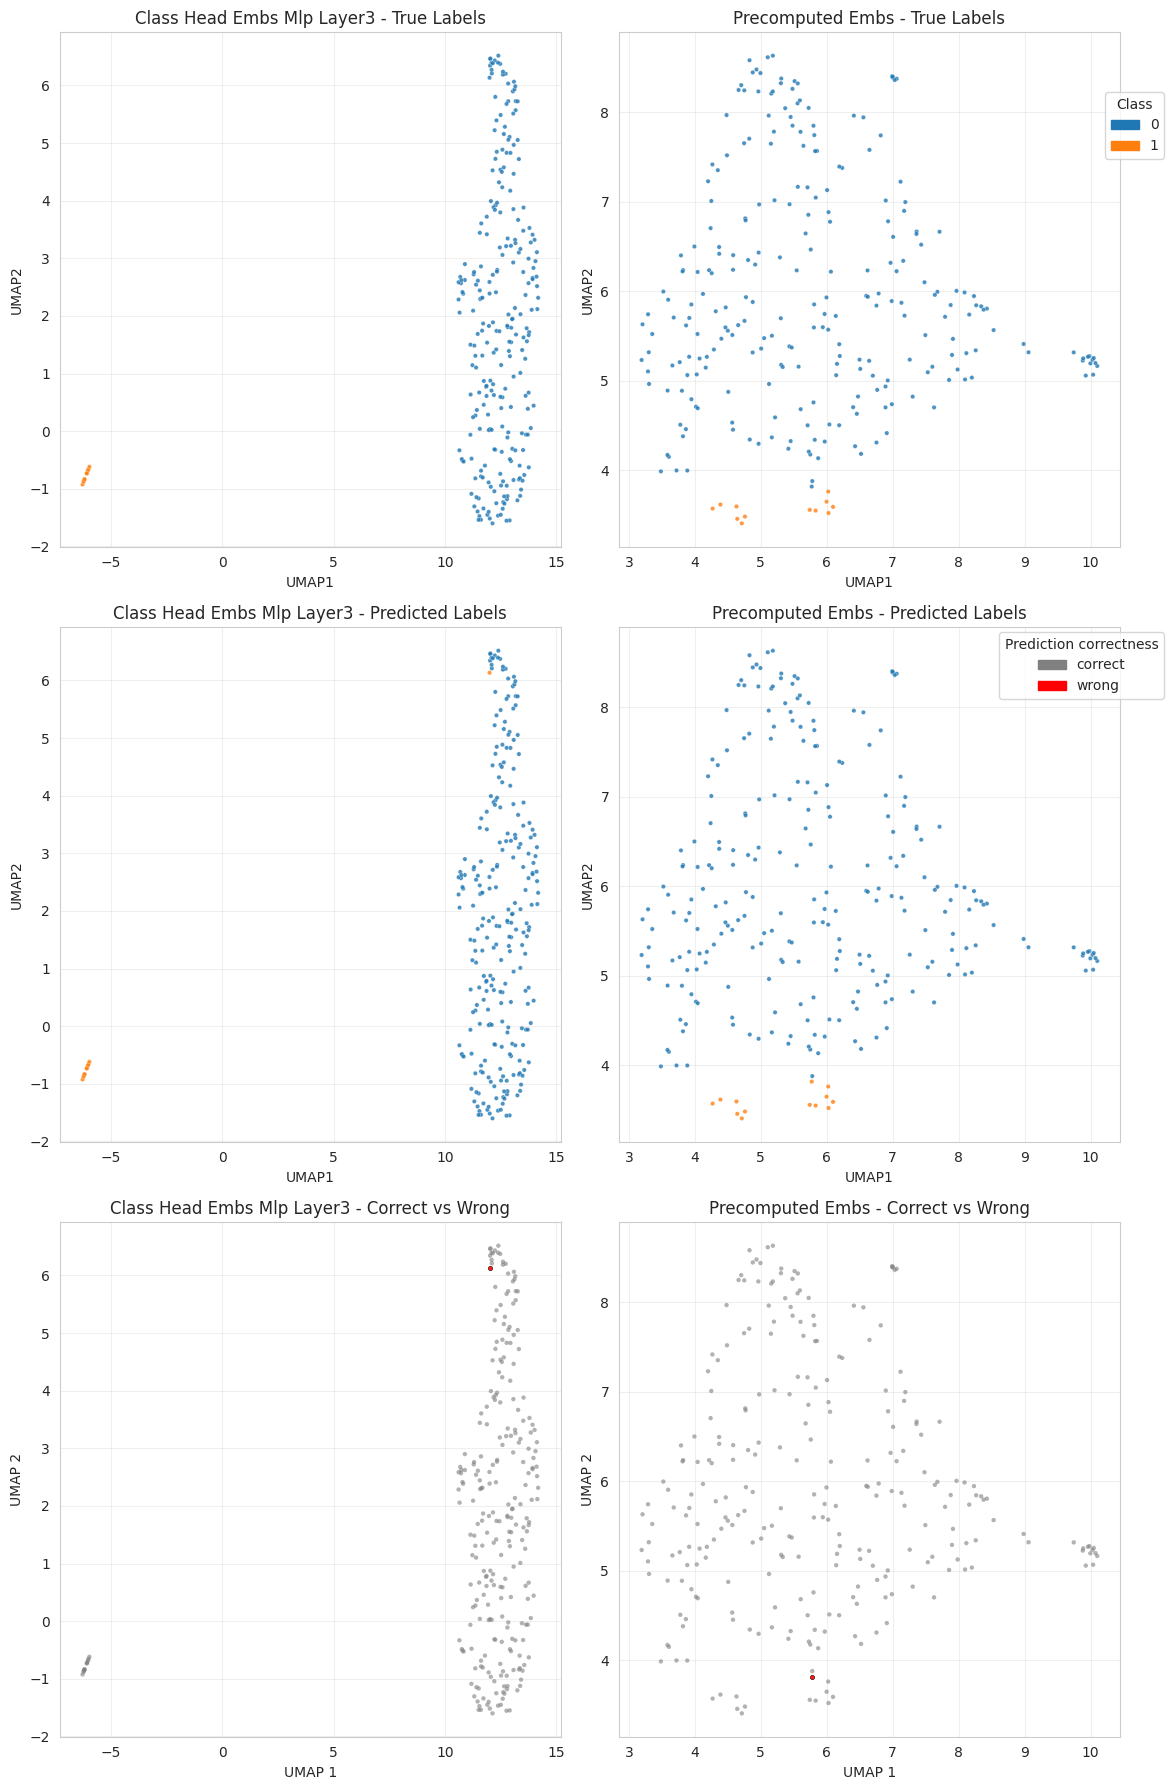

In [25]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(
        umap_tensors,
        names, 
        labels, 
        predictions, 
        class_palette = {str(k): v for k, v in enumerate(sns.color_palette("tab10", num_classes))},
        point_size=10)
else:
    print("No embs to plot")

In [26]:
df_precomputed = df["precomputed_embs"].copy()
#df_precomputed = df["class_head_embs_mlp_layer3"].copy()

# wrong lablled
TP_df = df_precomputed[(df_precomputed.CorrectStr == "correct") & (df_precomputed.TrueClass == "1")]
print(TP_df.Name.to_list())
display(TP_df)

FP_df = df_precomputed[(df_precomputed.TrueClass == "0") & (df_precomputed.PredClass == "1")]
print(FP_df.Name.to_list())
display(FP_df)

print("\nFalse Negatives")
FN_df = df_precomputed[(df_precomputed.TrueClass == "1") & (df_precomputed.PredClass == "0")]
print(FN_df.Name.to_list())
display(FN_df)

['Q4VXU2', 'Q07955', 'Q9NX07', 'Q9Y4C8', 'P0DJD4', 'Q9BQ04', 'Q13247', 'Q13242', 'Q9BRL6', 'Q96PK6', 'P51991', 'Q9NZI8']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
36,Q4VXU2,5.997950,3.650440,1,1,correct
64,Q07955,5.743386,3.559649,1,1,correct
78,Q9NX07,4.388465,3.618440,1,1,correct
91,Q9Y4C8,4.631864,3.597295,1,1,correct
107,P0DJD4,6.095345,3.592701,1,1,correct
130,Q9BQ04,4.643331,3.458769,1,1,correct
134,Q13247,4.270254,3.573809,1,1,correct
159,Q13242,5.831906,3.551224,1,1,correct
168,Q9BRL6,6.027524,3.524257,1,1,correct
175,Q96PK6,4.712817,3.408839,1,1,correct


['Q9GZL7']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
11,Q9GZL7,5.772892,3.819629,0,1,wrong



False Negatives
[]


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr


# A-scanning

In [ ]:
PROTEIN = "P31483" #df[(df["CorrectStr"] == "correct") & (df["TrueClass"] == "1")].iloc[0].Name

WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = ["A", "R", "E", "F"] #"<pad>", "A", "P"
WINDOW_SIZE_SUBSTITUION = 5 #int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print("window size: ", WINDOW_SIZE_SUBSTITUION)

##############################

net.from_precomputed_embs = False # need to recompute embs for each mutation
# ATTNETION: use SAME intial embs (embs passed to calssfricvation head) used IN TRAINING!!
net.type_emb_for_classification = config["TYPE_EMB_FOR_CLASSIFICATION"] 

##############################
# select single port data

idx = [cache_data["protein"].index(PROTEIN)] # encapslu in a lsit
selected_protein_data = my_dataset.subset_data_dict(cache_data, idx)
#print(selected_protein_data)

##############################
# calcualte baseline prob

baseline_prob = my_scanning.get_prob_single_protein(net, selected_protein_data, device="cuda")
print(baseline_prob)

##############################
# create all mutatios

all_mutated_seqs = my_scanning.create_all_mutations(selected_protein_data["truncated_sequence"][0], WINDOW_SIZE_SUBSTITUION, SUBSTITUTE_AA)
tot_mutations = len(all_mutated_seqs)
print(tot_mutations,  len(list(selected_protein_data["truncated_sequence"][0])) * len(SUBSTITUTE_AA))

# create dict
cache_mutations = {
    "protein": [selected_protein_data["protein"][0]] * tot_mutations,
    "label": torch.tensor([selected_protein_data["label"][0]] * tot_mutations),
    "set": [selected_protein_data["set"][0]] * tot_mutations,
    "sequence": [selected_protein_data["truncated_sequence"][0]], # use
    "truncated_sequence": all_mutated_seqs, 
}
# tokenize AS ABOVE (start ntoebook)
encoded = tokenizer(
    list(cache_mutations["truncated_sequence"]),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)
# add to dict
cache_mutations['input_ids'] =  encoded["input_ids"]  
cache_mutations[ 'attention_mask'] =  encoded["attention_mask"]
# ATTNETION: fake embs, as force to calculte here
cache_mutations["embedding"] = torch.zeros((tot_mutations, 1), dtype=torch.float32)



window size:  5


Evaluation:   0%|          | 0/1 [00:00<?, ? Single protein batch/s]

0.9080508947372437


Generating mutations:   0%|          | 0/386 [00:00<?, ?it/s]

1544 1544


In [38]:
scan_results = my_scanning.multi_aa_scanning_final(
    model=net,
    baseline_prob=baseline_prob,
    cache_mutations=cache_mutations,
    substitute_aas=SUBSTITUTE_AA,
    window_size=WINDOW_SIZE_SUBSTITUION,
    normalise_true_substitution=False,
    device="cuda", 
    batch_size=16
)

Evaluation:   0%|          | 0/97 [00:00<?, ? mutations batch/s]

KeyboardInterrupt: 

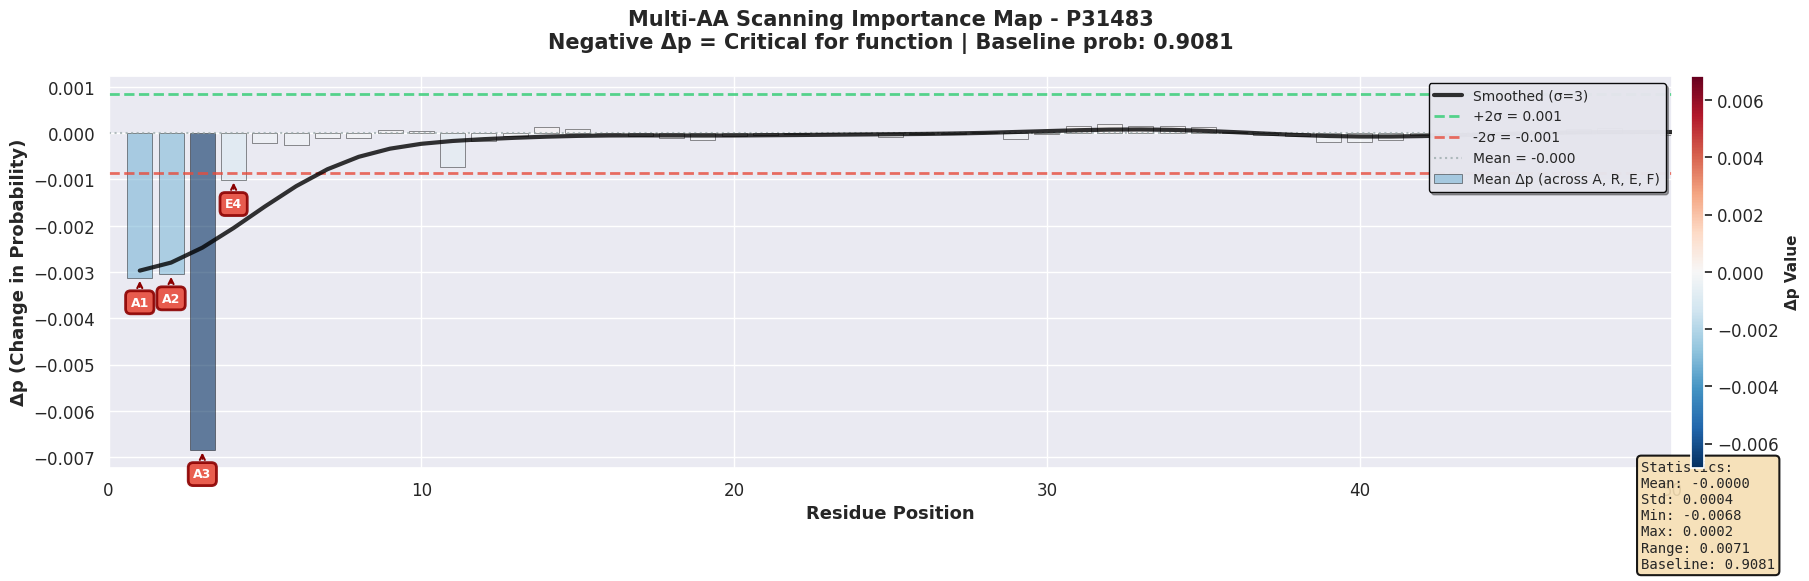


                      MULTI-AA SCANNING SUMMARY                       

Sequence Information:         
  Length:                   386
  Protein:                  P31483
  Substitute AAs:           A, R, E, F
  Baseline Probability:     0.9081

Statistical Summary:          
  Mean Δp:                  -0.0000
  Std Δp:                   0.0004
  Min Δp:                   -0.0068
  Max Δp:                   0.0002
  Threshold (+2σ):          0.0008
  Threshold (-2σ):          -0.0009

──────────────────────────────────────────────────────────────────────
             TOP CRITICAL RESIDUES (Largest Negative Δp)              
──────────────────────────────────────────────────────────────────────
Rank    Position    Residue     Δp             Status              
──────────────────────────────────────────────────────────────────────
1       3           A           -0.0068        ⚠️  Beyond threshold
2       1           A           -0.0031        ⚠️  Beyond threshold
3       2           A

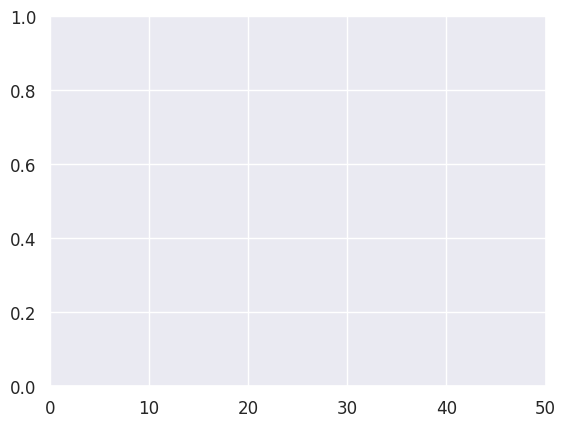

In [ ]:
my_scanning.plot_multi_aa_scan(scan_results.copy(), show_per_aa=False, figsize=(20,6), plot_range=[0,50])

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### A-scanning Logits

In [28]:
def prob_to_logit(p):
    """
    Convert probability of class 1 to logit (binary case)
    p: float or np.array of probabilities (0 < p < 1)
    returns: logit value(s)
    """
    p = np.clip(p, 1e-15, 1 - 1e-15)  # avoid log(0)
    return np.log(p / (1 - p))


PROTEIN = "P05997" #"Q6ZRI0" #"P01270" #"O60938" #"P05997"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = data_df[data_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

# Run alanine scanning
results = mf.alanine_scanning(
    model=net,
    tokenizer=tokenizer,
    single_protein_info=single_protein_info,
    window_size=WINDOW_SIZE_SUBSTITUION, # make it odd
    device=config["DEVICE"],
    SUBSTITUTE_AA=SUBSTITUTE_AA,
    normalise_true_substitution=True #normalise by number of true substitutions (not A->A
)

# calcuate logits
baseline_logit = prob_to_logit(results['baseline_prob'])
mutated_logits = prob_to_logit(results['mutated_probs'])
delta_logit = mutated_logits - baseline_logit

mf.plot_alanine_scan(
    delta_p=delta_logit,
    sequence=results['sequence'],
    protein_name=results['protein_name'],
    sigma=3,
    threshold=True,
    highlight_residues=True,
    top_n=10,
    show_sequence=False,
    style='whitegrid'  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)

NameError: name 'data_df' is not defined

### Random prot

In [ ]:
random_prot = "MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALGMYGTKMISCGQWRDQACYILYWVFWYPYFNVSQESIVLQYDLPHYGYDIFKPYINQTARCCPHHPQEAMNSEGNTVPACYAAVGQADPPIFDIAYSIMILRPLYGTCNPTGFQNVMNAIWSEEMAMFTQTHYVLPYRYPYQTYRLTSFSSRIMMENAGACEWESMVNFIFRTVAKRCKDKEYLFGNCAWTRLWSIAPHQWKWPSKNTHMYIDHFVEKGKQEELSNASWHTYLATSICPAHHHDWVWWNFEFWLCHFTEMDT"
random_label = 0
random_name = "Random_Prot"
random_data = pd.DataFrame([{
    'sequence': random_prot,
    'label': random_label,
    'protein': random_name,
    'set': 'test'
}])

# Preprocess each sequence individually
random_preprocessed_data = []
for idx, row in tqdm(random_data.iterrows(), total=len(random_data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    random_preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
random_data_df = pd.DataFrame(random_preprocessed_data)

# Add the 'set' column back from original data
random_data_df['set'] = random_data['set'].values

############################################

random_dl = my_dataset.create_dataloader(random_data_df, 'test', config["BATCH_SIZE"], shuffle=True)

# Optional: inspect the DataFrame
display(random_data_df.head(5))
#print(random_data_df.loc[0, "input_ids"])

In [ ]:
outputs = mf.evaluate_model(net, random_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

### Calibration

In [ ]:
outputs = mf.evaluate_model(net, test_dl, config["DEVICE"], loss_fn=loss_fn, split_name="Eval", verbose=True)
outputs

In [ ]:
probs = outputs['probs_class1']
print(probs)
sns.histplot(probs, kde=False, bins=30)  # kde=True if you also want a density curve
plt.show()

In [ ]:
# Calibration curve

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_true: 0 or 1 labels for your proteins
# y_prob: predicted probabilities for class 1

#x-axis = average predicted probability in that bin.
#y-axis = true fraction positive in that bin.

prob_true, prob_pred = calibration_curve(y_true=outputs['labels'], y_prob=outputs['probs_class1'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("Reliability diagram")
plt.legend()
plt.show()
